# Chest Cancer Detection

Using the `Chest CT-Scan Dataset` from [kaggle](https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images) dataset to train a model that can detect chest cancer from ct-scan images.In this project I will use `Functional API` and `Transfer Learning` using base model of `MobileNetv2` to train the dataset.

In [ ]:
# Import the necessary libraries
import os
import zipfile
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import train_test_split
from random import randint
import cv2

Download the dataset by running the cell below.

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [ ]:
!gdown "1CRuANxqfiSqUAGxlqoxkZWjnINHg5fUC&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1CRuANxqfiSqUAGxlqoxkZWjnINHg5fUC&confirm=t
To: /content/chest_ct-scan.zip
100% 43.2M/43.2M [00:00<00:00, 116MB/s] 


In [ ]:
!unzip chest_ct-scan.zip

Archive:  chest_ct-scan.zip
   creating: chest_ct-scan/
  inflating: __MACOSX/._chest_ct-scan  
  inflating: chest_ct-scan/.DS_Store  
  inflating: __MACOSX/chest_ct-scan/._.DS_Store  
   creating: chest_ct-scan/adenocarcinoma/
  inflating: __MACOSX/chest_ct-scan/._adenocarcinoma  
   creating: chest_ct-scan/squamous-cell-carcinoma/
  inflating: __MACOSX/chest_ct-scan/._squamous-cell-carcinoma  
   creating: chest_ct-scan/large-cell-carcinoma/
  inflating: __MACOSX/chest_ct-scan/._large-cell-carcinoma  
   creating: chest_ct-scan/normal/
  inflating: __MACOSX/chest_ct-scan/._normal  
  inflating: chest_ct-scan/adenocarcinoma/000122 (4).png  
  inflating: __MACOSX/chest_ct-scan/adenocarcinoma/._000122 (4).png  
  inflating: chest_ct-scan/adenocarcinoma/000118 (7).png  
  inflating: __MACOSX/chest_ct-scan/adenocarcinoma/._000118 (7).png  
  inflating: chest_ct-scan/adenocarcinoma/000126 (6).png  
  inflating: __MACOSX/chest_ct-scan/adenocarcinoma/._000126 (6).png  
  inflating: chest_ct-

Now the images are stored within the `/chest_ct-scan` directory. The directory is splitted to train, valid, test.
There is a subdirectory for each class.

In [ ]:
source_path = '/content/chest_ct-scan'

# Deletes corrupt images files
class_names = ['adenocarcinoma', 'squamous-cell-carcinoma', 'large-cell-carcinoma', 'normal']

for _class in class_names:
  folder_path = os.path.join(source_path, _class)
  for img_file in os.listdir(folder_path):
    path = os.path.join(folder_path, img_file)
    try:
      image=tf.keras.preprocessing.image.load_img(path)
    except:
      print(f'Removing {img_file} in {_class}')
      os.remove(path)

# os.listdir returns a list containing all files under the given path
for _class in class_names:
  print(f"There are {len(os.listdir(os.path.join(source_path, _class)))} images of {_class}.")

There are 120 images of adenocarcinoma.
There are 90 images of squamous-cell-carcinoma.
There are 51 images of large-cell-carcinoma.
There are 54 images of normal.


In [ ]:
def preview_sample(SOURCE_DIR, NUM_OF_IMGS):
  """
  Preview sample images from directories

  Args:
    SOURCE_DIR (string): directory path containing the images
    NUM_OF_IMGS (int): number sample of images to preview

  Returns:
    None
  """
  for i in range(NUM_OF_IMGS):
    img_class = random.choice(['adenocarcinoma', 'squamous-cell-carcinoma', 'large-cell-carcinoma', 'normal'])
    folder_path = os.path.join(SOURCE_DIR, img_class)
    img_path = os.listdir(folder_path)
    img = cv2.imread(os.path.join(folder_path, random.choice(img_path)))
    plt.imshow(img)
    plt.show()


Displaying random sample images from dataset

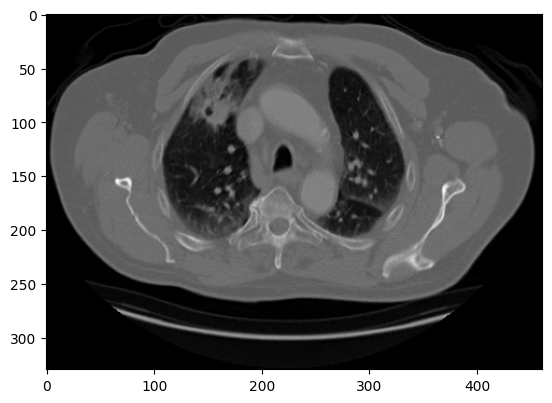

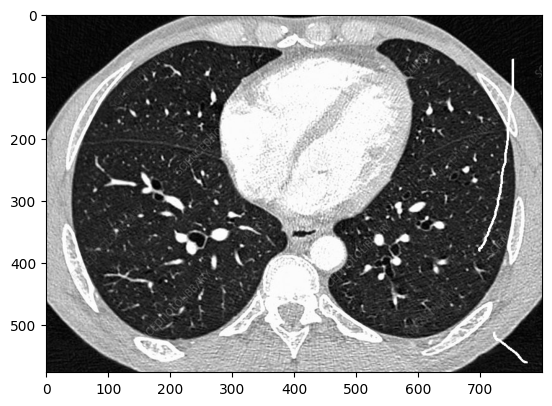

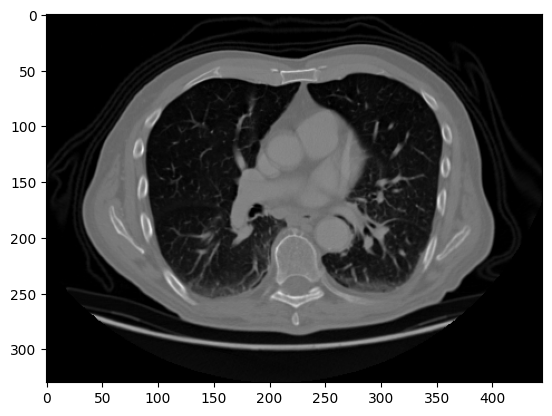

In [ ]:
img_path = preview_sample(source_path, 3)

Read Images and it's labels

In [ ]:
def load_dataset(SOURCE_DIR, CLASS_NAME, TARGET_SIZE):
  """
  Load images and labels from directories

  Args:
    SOURCE_DIR (string): directory path containing the images
    CLASS_NAME (array_like): Array of class names
    TARGET_SIZE (array_like): Dimension of the images

  Returns:
    array_like: Images data
    array_like: Images label
  """

  dataset = []
  label = []

  for _class in CLASS_NAME:
    tmp_dataset = []
    folder_path = os.path.join(SOURCE_DIR, _class)
    for img_file in os.listdir(folder_path):
      path = os.path.join(folder_path, img_file)
      try:
        image=tf.keras.preprocessing.image.load_img(path, color_mode='rgb',
              target_size=TARGET_SIZE)
      except:
        print(f'File {img_file} in {_class} is corrupted')
      else:
        image=tf.keras.preprocessing.image.load_img(path, color_mode='rgb',
            target_size=TARGET_SIZE)
        image=np.array(image)
        tmp_dataset.append(image)
        del image
        label.append(_class)
    dataset.append(np.asarray(tmp_dataset))
    del tmp_dataset
  dataset = np.concatenate(dataset, axis=0)

  # Label converter
  labels = []
  for _label in label:
    labels.append(CLASS_NAME.index(_label))

  # One hot encoder for multiple classes
  if len(CLASS_NAME) > 2:
    labels = tf.keras.utils.to_categorical(labels).astype(int)
  del label

  return dataset, np.asarray(labels)

In [ ]:
class_name = ['adenocarcinoma', 'squamous-cell-carcinoma', 'large-cell-carcinoma', 'normal']
img_size = (160,160)
dataset, labels = load_dataset(source_path, class_name, img_size)

In [ ]:
# Checking dataset and labels shape
print(dataset.shape)
print(labels.shape)

(315, 160, 160, 3)
(315, 4)


In [ ]:
# Train test split
train_data, test_data, label_train, label_test = train_test_split(dataset, labels, train_size=0.9, shuffle=True)

In [ ]:
# Checking train, test, and it's label shape
print(train_data.shape)
print(label_train.shape)
print(test_data.shape)
print(label_test.shape)

(283, 160, 160, 3)
(283, 4)
(32, 160, 160, 3)
(32, 4)


Defining our transfer learning model using MobileNetV2

In [ ]:
def create_model():
  # Define out base model
  base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')
  base_model.trainable = False # Freeze the base model

  # We need to prepocess our input
  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

  # Add classifier
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(4, activation='softmax')

  # Let's Combine our model with Functional API
  inputs = tf.keras.Input(shape=(160, 160, 3)) #functional API harus nentuin satu input
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.5)(x) # Adding the dropout to prevent overfitting
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  # Compile our model
  model.compile(loss='categorical_crossentropy',
              metrics=['categorical_accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


  return model

In [ ]:
# Get the untrained model
model = create_model()

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# Display model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [ ]:
# Train the model
# Note that this may take some time.
history = model.fit(train_data, label_train,batch_size=64, validation_split=0.1, epochs=50)

Epoch 1/50
4/4 [==============================] - 14s 671ms/step - loss: 2.2709 - categorical_accuracy: 0.2598 - val_loss: 1.5639 - val_categorical_accuracy: 0.4138
Epoch 2/50
4/4 [==============================] - 0s 72ms/step - loss: 1.8787 - categorical_accuracy: 0.3465 - val_loss: 1.2709 - val_categorical_accuracy: 0.4828
Epoch 3/50
4/4 [==============================] - 0s 60ms/step - loss: 1.7330 - categorical_accuracy: 0.3976 - val_loss: 1.0696 - val_categorical_accuracy: 0.6207
Epoch 4/50
4/4 [==============================] - 0s 64ms/step - loss: 1.4687 - categorical_accuracy: 0.4370 - val_loss: 0.9242 - val_categorical_accuracy: 0.6897
Epoch 5/50
4/4 [==============================] - 0s 80ms/step - loss: 1.2253 - categorical_accuracy: 0.5118 - val_loss: 0.8606 - val_categorical_accuracy: 0.6552
Epoch 6/50
4/4 [==============================] - 0s 78ms/step - loss: 1.1612 - categorical_accuracy: 0.5000 - val_loss: 0.8423 - val_categorical_accuracy: 0.6207
Epoch 7/50
4/4 [====

check the training and validation accuracy achieved at the end of each epoch.

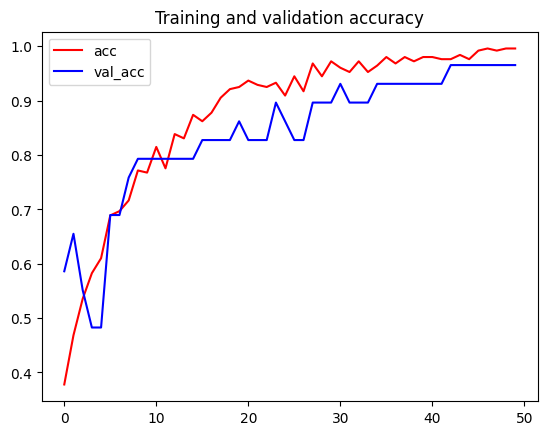

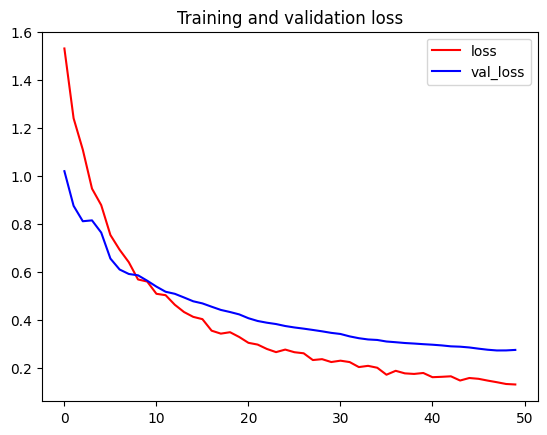

In [ ]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label='acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Test the model

In [ ]:
def make_prediction(model, data, label, CLASS_NAME):
  """
  Preview sample images from directories

  Args:
    model: trained model
    data (array-like): data to predict
    label (array-like) : true label of data
    CLASS_NAME (array_like): Array of class names

  Returns:
    None
  """

  idx = randint(0, label.shape[0]-1)
  x = np.expand_dims(data[idx], axis=0)
  y_pred = model.predict(x)
  y_pred = np.argmax(y_pred)
  y = np.argmax(label[idx])
  plt.imshow(data[idx])
  plt.xlabel(f'Predicted class: {CLASS_NAME[y_pred]}\nActual class: {CLASS_NAME[y]}')
  plt.show()


1/1 [==============================] - 0s 25ms/step


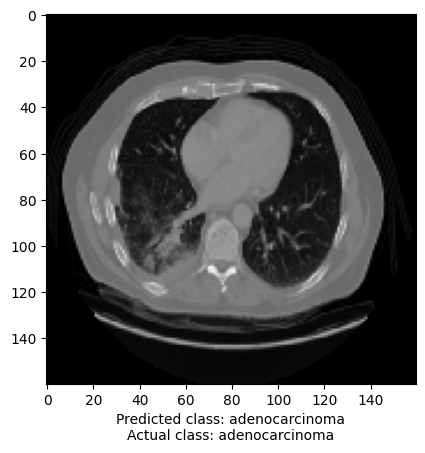

In [ ]:
make_prediction(model, test_data, label_test, class_name)